In [1]:
from typing import TypedDict
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
import json, os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
load_dotenv()

i:\fuse\Csa\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
# llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
llm = ChatOpenAI(
    api_key = os.getenv("OPENROUTER_API_KEY"),
    base_url = "https://openrouter.ai/api/v1",
    model = "google/gemini-2.5-flash",
    max_completion_tokens=500
)

In [3]:
from langsmith import Client

client = Client()

In [4]:
import requests
from langchain_core.tools import tool
from typing import Optional
import os, requests

@tool
def menu_tool(
    search: Optional[str] = None,
    type: Optional[str] = None,
    price_min: Optional[float] = None,
    price_max: Optional[float] = None,
) -> dict:
    """
    Retrieves restaurant menu items based on the provided criteria.

    Args:
        search (str | None): Dish name or keyword to search for.
        type (str | None): "veg" or "nonveg" to filter dish type.
        price_min (float | None): Minimum price filter.
        price_max (float | None): Maximum price filter.

    Returns:
        dict: Dictionary containing matching menu items
    """
    base_url = os.getenv("BASE_URL")
    params = {
        "search": search,
        "type": type,
        "price_min": price_min,
        "price_max": price_max
    }

    try:
        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error calling backend: {e}")
        return {"error": str(e)}


@tool
def kb_tool(query:str) -> str:
    """
    Retrieves restaurant knowledge base information based on a user query.

    Args:
        query (str): Question or topic related to restaurant policies, FAQs, or general info.

    Returns:
        str: Retreived info
    """
    return "Lumina Bistro is a restaurant located at Jhamsikhel, Lalitpur."

In [5]:
tools = [menu_tool, kb_tool]

llm_with_tools = llm.bind_tools(tools)

tools_node = ToolNode(tools=tools)

In [6]:
from typing import TypedDict, Annotated, List, Optional, Literal
from langgraph.graph.message import add_messages
from langchain.schema import BaseMessage
from pydantic import BaseModel

class ReviewDecision(BaseModel):
    decision: Literal["ok", "needs_more"]
    rationale: str = ""
    answer: str = ""
    todo: str = ""

class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    review_decision: Optional[ReviewDecision]
    summary: Optional[str]
    tool_output: Optional[str]

In [7]:
ORCHESTRATOR_PROMPT = """SYSTEM:
You are a restaurant assistant agent. You have access to the following tools:

1. menu_tool
   Description: Returns menu items based on the following input parameters.
   Inputs:
     - search (string | null): Dish or keyword to search
     - type (string | "veg"/"non-veg"/null): Dish type
     - price_min (number | null): Minimum price
     - price_max (number | null): Maximum price
   Output: JSON object with matching menu items

2. kb_tool
   Description: Answers general knowledge questions about the restaurant.
   Inputs:
     - query (string): The question or topic
   Output: JSON object containing the answer

Your responsibilities:
- Read the user's message and your current memory.
- Decide which tool(s), if any, need to be called. Only call a tool if the required info is missing or outdated.
- Extract all required inputs for the tools from the user query and memory.
- Generate a concise response to the user using available tool results or memory.

Instructions for output:
Respond with a JSON object with the following keys:

{
  "tool_calls": [
    {
      "tool_name": "menu_tool" | "kb_tool",
      "inputs": { ... }  # filled input parameters
    }
  ],
  "answer": "string",         # final assistant message
  "updated_memory": {         # updated state to store
    "tasks": [...],
    "entities": {...}
  }
}

Rules:
- Do not hallucinate: only use memory or tool results.
- Reuse previous results if the same task with same slots is already done.
- If the user's request cannot be answered with existing memory and tool info, politely ask for clarification.
- Be concise (1-3 sentences) in your answers.
"""

In [59]:
from langchain.schema import SystemMessage, AIMessage

def orchestrator(state: State):
    """
    Node to classify user intent using the LLM with tools.
    Updates state['messages'] and state['summary'] in-place.
    """
    # ensure summary exists
    state.setdefault("summary", "")

    # prepend system prompt to conversation
    messages = [SystemMessage(content=ORCHESTRATOR_PROMPT)]

    # Include summary if present
    if state.get("summary"):
        messages.append(SystemMessage(content=f"Summary:\n{state['summary']}"))

    # Include review_decision if present
    if state.get("review_decision"):
    # Use model_dump() for Pydantic v2
        review_dict = state["review_decision"].model_dump() if hasattr(state["review_decision"], "model_dump") else state["review_decision"]
        messages.append(SystemMessage(content=f"Review Decision:\n{review_dict}"))

    # call LLM with tools
    resp = llm_with_tools.invoke(messages)

    # append AIMessage content to summary
    if isinstance(resp, AIMessage) and getattr(resp, "content", ""):
        state["summary"] += f"\nAI: {resp.content}"

    # append response to messages
    state["messages"].append(resp)

    # return minimal dict; state is already updated
    return state


In [51]:
import json
from collections import defaultdict

def compact_menu_summary(tool_content, max_items_shown=7):
    """
    Summarize menu_tool JSON output:
    - If <= max_items_shown, return raw content.
    - If > max_items_shown, group by category and list names.
    Returns (summary_text, overflow_flag)
    """
    try:
        items = json.loads(tool_content)
    except Exception:
        return tool_content, False  # fallback

    total_items = len(items)
    
    if total_items <= max_items_shown:
        return tool_content, False  # small, keep as-is

    # group by category
    grouped = defaultdict(list)
    for item in items:
        cat = item.get("category_name") or "Other"
        grouped[cat].append(item.get("name", "item"))

    summary_lines = [f"{cat}: {', '.join(names)}" for cat, names in grouped.items()]
    summary_lines.append("Above is the data received from menu_tool call applying user's preferences.")
    return "\n".join(summary_lines), True


In [95]:
def tool_summarizer_node(state):
    """
    Summarizes tool messages and appends to state['tool_output'].
    Only includes messages that have a name attribute (i.e., tool outputs).
    """
    state.setdefault("tool_output", "")

    for msg in state.get("messages", []):
        if not hasattr(msg, "name") or not hasattr(msg, "content"):
            continue

        name = msg.name
        content = msg.content

        # Ensure content is a string
        if content is None:
            content = ""
        elif isinstance(content, list):
            content = json.dumps(content) if content else "No matches found."

        if not name:
            continue

        if name == "menu_tool":
            summary_text, overflow = compact_menu_summary(content)
            state["tool_output"] += f"\nmenu_tool output: {summary_text}"
        else:
            state["tool_output"] += f"\n{name} output:\n{content}"


    return state


In [83]:
# from typing import Literal
# from pydantic import BaseModel

reviewer_llm = llm 
# class ReviewDecision(BaseModel):
#     decision: Literal["ok", "needs_more"]
#     rationale: str = ""
#     answer: str = ""
#     todo: str = ""

REVIEWER_PROMPT = """You are a restaurant assitant agent who can answer general questions about this restaurant and menu queries.
Compare the user's request with the latest tool outputs in the conversation if needed.
- Find out if the user's query requires following tool calls:
1. menu_tool: Returns menu items based on the following input parameters.
2. kb_tool: Answers general knowledge questions about the restaurant.
If so, check if the required tool calls has happened, set decision="ok" and use the tool output as reference to produce a natural, concise answer to the user in the 'answer' field.
If no tool calls are required, answer like a friendly restaurant assistant.
- If the required tool calls are missing, set decision="needs_more" and explain what additional information or tool calls are needed in the 'todo' field.
- When providing an answer, summarize options clearly and include prices if provided, grouped by category if needed, so it reads like a reply to the user.

Return a JSON object with fields:
- decision: "ok" | "needs_more"
- rationale: brief reason
- answer: final user-facing answer if decision == "ok", else ""
- todo: what is still needed if decision == "needs_more"

"""

# Wrap the model to return the Pydantic object directly:
structured_reviewer = reviewer_llm.with_structured_output(ReviewDecision)

def reviewer_node(state: State):
    from langchain.schema import SystemMessage
    msgs = [SystemMessage(content=REVIEWER_PROMPT)]

    # include summary as a system message (compressed menu_tool output)
    if "summary" in state and state["summary"]:
        msgs.append(SystemMessage(content=f"Summary: {state['summary']}"))
    
    if "tool_output" in state and state["tool_output"]:
        msgs.append(SystemMessage(content=f"Tool Output: {state['tool_output']}"))

    # Call structured reviewer
    review: ReviewDecision = structured_reviewer.invoke(msgs)
    
    updates = {}

    # Ensure summary exists
    state.setdefault("summary", "")

    # Append AI answer to summary if decision is "ok"
    if review.decision == "ok" and review.answer:
        state["summary"] += f"\nAI: {review.answer}"

    # Store the full ReviewDecision object in state
    state["review_decision"] = review

    # Keep messages as before
    updates["messages"] = [AIMessage(content=review.answer)] if review.decision == "ok" else [SystemMessage(content=f"Reviewer: needs more info → {review.todo}")]

    return state

In [96]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition


def route_after_reviewer(state: State):
    return "orchestrator_node" if state.get("review_decision") == "needs_more" else "__end__"

def build_graph():
    g = StateGraph(State)

    g.add_node("orchestrator_node", orchestrator)
    g.add_node("tools", tools_node)          # or tools_node.invoke
    g.add_node("reviewer", reviewer_node)
    g.add_node("summarize_menu_tool",tool_summarizer_node)

    g.add_edge(START, "orchestrator_node")

    # If assistant asked for tools, go to tools; otherwise go to reviewer
    g.add_conditional_edges(
        "orchestrator_node",
        tools_condition,
        {"tools": "tools", "__end__": "reviewer"},
    )

    g.add_edge("tools", "summarize_menu_tool")

    g.add_edge("summarize_menu_tool", "reviewer")

    # Reviewer decides whether to loop back or end
    g.add_conditional_edges(
        "reviewer",
        route_after_reviewer,
        {"orchestrator_node": "orchestrator_node", "__end__": END},
    )

    return g.compile()


In [97]:
graph = build_graph()


In [98]:
from langchain.schema import HumanMessage

# user query
user_input = "hey i want to visit you guys if you serve spagetti also tell me where are you located"
human_msg = HumanMessage(content=user_input)

# ensure state exists
state = {
    "messages": [],
    "summary": "",
    "review_decision": ReviewDecision(decision="needs_more", rationale="", answer="", todo="")
}

state["messages"].append(human_msg)
state["summary"] += f"\nHuman: {human_msg.content}"
# invoke the graph
result = graph.invoke(state)  # state is mutated in-place

# now extract the final user-facing answer
final_answer = result["review_decision"].answer

# and also get the summary for chat history
chat_summary = result["summary"]

In [100]:
chat_summary

'\nHuman: hey i want to visit you guys if you serve spagetti also tell me where are you located\nAI: We do not serve spaghetti at Lumina Bistro. You can find us at Jhamsikhel, Lalitpur. We look forward to seeing you!'

In [94]:
result["messages"]

[HumanMessage(content='hey i want to visit you guys if you serve spagetti also tell me where are you located', additional_kwargs={}, response_metadata={}, id='f710c4a2-bc84-407c-a2ad-030e46d7f42a'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tool_0_menu_tool_qCH4xP78XPJd3ZfY7NsT', 'function': {'arguments': '{"search":"spagetti"}', 'name': 'menu_tool'}, 'type': 'function', 'index': 0}, {'id': 'tool_1_kb_tool_4xqahthOk85wIt0J5rzD', 'function': {'arguments': '{"query":"location"}', 'name': 'kb_tool'}, 'type': 'function', 'index': 1}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 632, 'total_tokens': 643, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'google/gemini-2.5-flash', 'system_fingerprint': None, 'id': 'gen-17

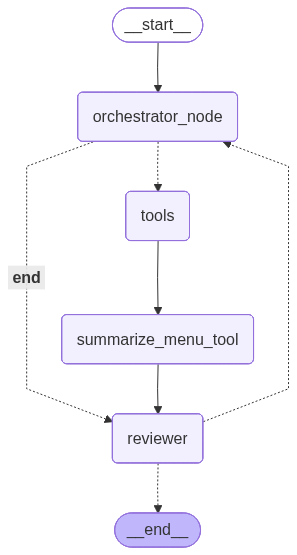

In [ ]:
build_graph()

In [ ]:
result

{'messages': [HumanMessage(content='what kind of pizzas you have', additional_kwargs={}, response_metadata={}, id='21568fe2-9e51-4e6f-9588-85e8e6621660'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tool_0_menu_tool_gzwZWuDN87jXPpIdtro6', 'function': {'arguments': '{"search":"pizza"}', 'name': 'menu_tool'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 5, 'prompt_tokens': 588, 'total_tokens': 593, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'google/gemini-2.5-flash', 'system_fingerprint': None, 'id': 'gen-1761652599-1beOt8mIenykl87y815g', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c49d9c51-5ac2-4503-8719-428bce8a37a0-0', tool_calls=[{'name': 'menu_tool', 'args': 

In [ ]:
result["messages"][-1].content

'We have several delicious pizzas:\n\nNon-Veg:\n* Smoky BBQ Chicken Pizza: grilled chicken, barbecue glaze, onions, bell peppers, extra cheese for 550.00.\n* Spicy Buff & Jalapeño Pizza: marinated buff, jalapeños, olives, spicy chick-tomato sauce for 580.00.\n* Meat Lovers Combo Pizza: pepperoni, salami, chicken, bacon (or substitute local meats), extra cheese for 600.00.\n\nVeg:\n* Veggie Supreme Pizza: mushrooms, capsicum, olives, sweet corn, extra mozzarella & herbs for 450.00.'

In [ ]:
result["summary"]

'\nHuman: what kind of pizzas you have'